<a href="https://colab.research.google.com/github/kundajelab/feature_interactions/blob/master/softplus_poisson/TrainModels_PoissonLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#download raw data
!wget https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_simulation.simdata.gz
!wget https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_neg_labels.txt.gz
!wget https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_pos_labels.txt.gz

--2020-06-24 20:19:47--  https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_simulation.simdata.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/feature_interactions/f761fd8182c19931c16f7e3a5e562394dce443d2/av/data/train_simulation.simdata.gz [following]
--2020-06-24 20:19:48--  https://raw.githubusercontent.com/kundajelab/feature_interactions/f761fd8182c19931c16f7e3a5e562394dce443d2/av/data/train_simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2104123 (2.0M) [application/octet-stream]
Saving to: ‘train_simulation.simdata.gz’

train_simulati

In [ ]:
!gunzip *.gz

In [ ]:
!md5sum *

md5sum: sample_data: Is a directory
1f2ddf5f3a74e3db548c5d2180d29a45  train_neg_labels.txt
262ca284f5f8676b16c8bf92047cfe70  train_pos_labels.txt
fb82dd3c7dc4b53d34b4fd456394de42  train_simulation.simdata


In [ ]:
!pip install simdna

In [ ]:
import simdna
from simdna import synthetic

In [ ]:
train_data = synthetic.read_simdata_file("train_simulation.simdata")

In [ ]:
import numpy as np


#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_labels_and_oracle(filename):
  labels = np.array([float(x.split("\t")[0]) for
                                          x in open(filename)])
  oracle = np.array([float(x.split("\t")[1]) for
                                          x in open(filename)])
  return labels, oracle


train_onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                              for seq in train_data.sequences])

train_pos_labels, train_pos_oracle =\
  read_labels_and_oracle("train_pos_labels.txt")
train_neg_labels, train_neg_oracle =\
  read_labels_and_oracle("train_neg_labels.txt")

Train models

In [ ]:
#define model architectures

import keras
import string
import random
import numpy as np
from keras import backend as B

def steeper_softplus():
  return keras.layers.Activation("softplus") #stick to standard for now
  #log_scalefactor = np.log(10)
  #return keras.layers.Lambda(lambda x: B.log(
  #    1+B.exp(log_scalefactor*x))/log_scalefactor)


#This model is a sanity check - it cannot learn interactions between motifs
# except ones that are within the same receptive field. I am giving it a
# wide receptive field on the first layer so it can likely learn the full
# motif properly.
def model_arch_sanitycheck(l1_reg):
  inputs = keras.layers.Input(shape=(100,4))
  conv = keras.layers.Conv1D(filters=64, kernel_size=25,
                activation='sigmoid', padding='valid',
                kernel_regularizer=keras.regularizers.l1(l1_reg))(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  #
  predictions = steeper_softplus()(
                 keras.layers.Dense(1, kernel_initializer="he_normal",
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out))
  model = keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer='adam', loss=keras.losses.poisson,
                metrics=["mse"])
  return model

#This model can learn the ground truth via a skip connection, but also
# has the capacity to learn interactions
def model_arch_skipconn(l1_reg):
  inputs = keras.layers.Input(shape=(100,4))
  conv = keras.layers.Conv1D(filters=64, kernel_size=25,
                activation='sigmoid', padding='valid',
                kernel_regularizer=keras.regularizers.l1(l1_reg))(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  output_part1 = keras.layers.Dense(1,
                 kernel_initializer="he_normal",
                 activation='linear',
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out)
  dense_1 = keras.layers.Dense(64, activation='relu',
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out)
  output_part2 = keras.layers.Dense(1,
                 kernel_initializer="he_normal",
                 activation='linear',
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(dense_1)
  combined_output = keras.layers.add([output_part1, output_part2])
  predictions = steeper_softplus()(combined_output)
  model = keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer='adam', loss=keras.losses.poisson,
                metrics=["mse"])
  return model


#This model has one dense layer and no slip connection
def model_arch_onelayer(l1_reg):
  inputs = keras.layers.Input(shape=(100,4))
  conv = keras.layers.Conv1D(filters=64, kernel_size=25,
                activation='sigmoid', padding='valid',
                kernel_regularizer=keras.regularizers.l1(l1_reg))(inputs)
  conv_out = keras.layers.GlobalAveragePooling1D()(conv)
  dense_1 = keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1(l1_reg))(conv_out)
  predictions = steeper_softplus()(keras.layers.Dense(1,
                 kernel_initializer="he_normal",
                 activation='linear',
                 kernel_regularizer=keras.regularizers.l1(l1_reg))(dense_1))
  model = keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer='adam', loss=keras.losses.poisson,
                metrics=["mse"])
  return model


def train_and_save_model(model_constructor, prefix, X_train, y_train,
                         X_valid, y_valid, seed):
  
  barcode = ''.join(random.choice(string.ascii_lowercase) for i in range(5))
  np.random.seed(seed)
  model = model_constructor()
  save_filename = prefix+"_"+barcode+".h5"
  print("Training model", save_filename)
  print(model.summary())
  model.fit(x=X_train, y=y_train, batch_size=200,
            epochs=1000,
            validation_data=(X_valid, y_valid),
            callbacks=[keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=15,
                        restore_best_weights=True)])
  
  print("Save file name", save_filename)
  model.save(save_filename)
  return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ln -s /content/drive/My\ Drive/colab_notebook_data/ .

In [ ]:
!mkdir -p colab_notebook_data/feature_interactions/trained_models/poissonloss

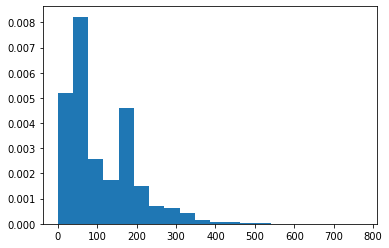

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(train_pos_labels, density=True, bins=20)
plt.show()

In [ ]:
#train the models

indices_train = np.arange(0, int(0.8 * train_onehot_data.shape[0]))
indices_valid = np.arange(int(0.8 * train_onehot_data.shape[0]),
                              train_onehot_data.shape[0])

SAVEDIR = "colab_notebook_data/feature_interactions/trained_models/poissonloss"

for seed in [100, 200, 300, 400, 500]:
  for l1_reg in [0.0, 0.00001, 0.0001]:
    for model_constructor, archname in [(model_arch_sanitycheck, 'sanitycheck'),
                                        (model_arch_skipconn, 'skipconn'),
                                        (model_arch_onelayer, 'onelayer')]:
        train_and_save_model(
            model_constructor=lambda: model_constructor(l1_reg),
            prefix=(SAVEDIR+"/poscontrol_model-"+archname
                    +"_l1reg-"+str(l1_reg)+"_seed"+str(seed)),
            X_train=train_onehot_data[indices_train],
            y_train=train_pos_labels[indices_train],
            X_valid=train_onehot_data[indices_valid],
            y_valid=train_pos_labels[indices_valid],
            seed=seed) #vary the seed for initialization diversity
        
        train_and_save_model(
            model_constructor=lambda: model_constructor(l1_reg),
            prefix=(SAVEDIR+"/negcontrol_model-"+archname
                    +"_l1reg-"+str(l1_reg)+"_seed"+str(seed)),
            X_train=train_onehot_data[indices_train],
            y_train=train_neg_labels[indices_train],
            X_valid=train_onehot_data[indices_valid],
            y_valid=train_neg_labels[indices_valid],
            seed=seed) #vary the seed for initialization diversity


Streaming output truncated to the last 5000 lines.
Epoch 626/1000
40000/40000 [==============================] - 1s 18us/step - loss: -531.7143 - mse: 3577.8521 - val_loss: -531.2018 - val_mse: 3648.0208
Epoch 627/1000
40000/40000 [==============================] - 1s 18us/step - loss: -531.7235 - mse: 3576.3904 - val_loss: -531.2068 - val_mse: 3652.2805
Epoch 628/1000
40000/40000 [==============================] - 1s 17us/step - loss: -531.7318 - mse: 3575.1587 - val_loss: -531.2208 - val_mse: 3635.0420
Epoch 629/1000
40000/40000 [==============================] - 1s 17us/step - loss: -531.7458 - mse: 3570.0664 - val_loss: -531.2171 - val_mse: 3657.4197
Epoch 630/1000
40000/40000 [==============================] - 1s 18us/step - loss: -531.7517 - mse: 3571.7507 - val_loss: -531.2247 - val_mse: 3656.6721
Epoch 631/1000
40000/40000 [==============================] - 1s 18us/step - loss: -531.7627 - mse: 3569.8228 - val_loss: -531.2407 - val_mse: 3647.7900
Epoch 632/1000
40000/40000 [===